In [1]:
import os
import glob
import sys
import getpass
import importlib
from tqdm import tqdm
from pathlib import Path

# user path:
usrname = getpass.getuser()
# add paths:
sys.path.append(f'/Users/{usrname}/Desktop/Projects')
sys.path.append(f'/Users/{usrname}/Desktop/Projects/bimanual_wrist')
sys.path.append(f'/Users/{usrname}/Desktop/Projects/Functional_Fusion')
sys.path.append(f'/Users/{usrname}/Desktop/Projects/PcmPy')


import rsatoolbox as rsa
from rsatoolbox.io import spm as spm_io
import surfAnalysisPy as surf
import SUITPy as suit
import nibabel as nb
import nitools as nt
import PcmPy as pcm
import Functional_Fusion.atlas_map as am
import Functional_Fusion.reliability as rel

import matplotlib.pyplot as plt
import matplotlib
from matplotlib.cm import ScalarMappable
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.patches as patches
import seaborn as sns

import scipy.stats as stats
import scipy
import scipy.io as sio
import numpy as np
import pandas as pd

import utils
importlib.reload(utils)

# SET PATHS:
baseDir = os.path.join('/Users', getpass.getuser(), 'Desktop', 'Projects', 'bimanual_wrist', 'data', 'fMRI')
bidsDir = 'BIDS'
anatomicalDir = 'anatomicals'
freesurferDir = 'surfaceFreesurfer'
surfacewbDir = 'surfaceWB' 
behavDir = 'behavioural'
regDir = 'ROI'
atlasDir = '/Volumes/diedrichsen_data$/data/Atlas_templates/fs_LR_32'
analysisDir = os.path.join(os.path.dirname(os.path.dirname(baseDir)), 'analysis')



# Build datast

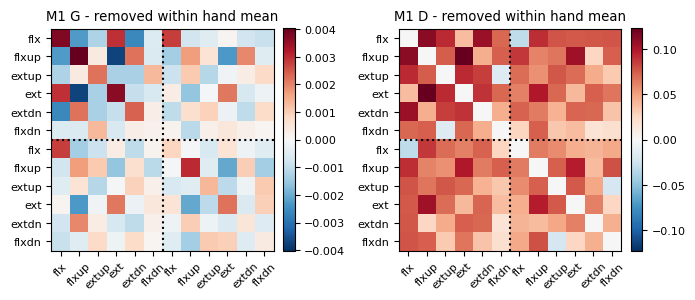

In [8]:
labels = ['flx', 'flxup', 'extup', 'ext', 'extdn', 'flxdn', 'flx', 'flxup', 'extup', 'ext', 'extdn', 'flxdn']
labels_lateral = ['contra']*6 + ['ipsi']*6
cmap = 'RdBu_r'
sn_bad = [102, 103]
regions = ['M1','S1','PMd','PMv','SMA','SPLa','SPLp','V1']
hem = ['L','R']

region = regions[0]
data, cond_vec, part_vec = [], [], []
for i_hem, h in enumerate(hem):
    roi = f'{region}_{h}'
    file_path = os.path.join(analysisDir, f'pwbeta_{roi}.npz')
    d = np.load(file_path, allow_pickle=True)

    subject = d['subject']
    indices = [k for k, s in enumerate(subject) if s not in sn_bad]

    subject = d['subject'][indices]
    cond_name_tmp = d['cond_intrinsic_vec'][indices]
    cond_vec_tmp = d['cond_num_vec'][indices]
    data_tmp = d['beta_white'][indices]
    part_tmp = d['part_vec'][indices]

    for i_sub in range(len(subject)):
        idx1 = [j for j, c in enumerate(cond_name_tmp[i_sub]) if 'rhand' in c]
        idx2 = [j for j, c in enumerate(cond_name_tmp[i_sub]) if 'lhand' in c]
        idx = idx1 + idx2
        # Y = data_tmp[i_sub][idx, :]
        Y1 = data_tmp[i_sub][idx1, :]
        Y2 = data_tmp[i_sub][idx2, :]

        # remove mean of voxels across conditions of rhand:
        rhand_parts = part_tmp[i_sub][idx1]
        for p in np.unique(rhand_parts):
            Y1[rhand_parts == p, :] = Y1[rhand_parts == p, :] - np.mean(Y1[rhand_parts == p, :], axis=0)
        # remove mean of voxels across conditions of lhand:
        lhand_parts = part_tmp[i_sub][idx2]
        for p in np.unique(lhand_parts):
            Y2[lhand_parts == p, :] = Y2[lhand_parts == p, :] - np.mean(Y2[lhand_parts == p, :], axis=0)
        Y = np.vstack((Y1, Y2))

        subj_part = part_tmp[i_sub][idx]
        # Sort the conditions so that contralateral condition comes first.
        # Also, within hand order is flx, flxup, extup, ext, extdn, flxdn.
        # refer to notebooks_mri/extract_data.ipynb to understand exactly why this works:
        if h == 'L':
            subj_cond = cond_vec_tmp[i_sub][idx]
            tmp = subj_cond.copy()
            subj_cond[tmp > 5] = tmp[tmp > 5] - 6
            subj_cond[tmp <= 5] = tmp[tmp <= 5] + 6 
        elif h == 'R':
            subj_cond = cond_vec_tmp[i_sub][idx]

        data.append(Y)
        cond_vec.append(np.array(subj_cond))
        part_vec.append(subj_part)

Y = []
# --- RDM Calculation ---
for i_sub in range(len(data)):
    obs_des = {'cond_vec': cond_vec[i_sub], 'part_vec': part_vec[i_sub]}
    Y.append(pcm.dataset.Dataset(data[i_sub], obs_descriptors=obs_des))

N = len(Y)
ncond = len(np.unique(Y[0].obs_descriptors['cond_vec']))
G_hat = np.zeros((N, ncond, ncond))
for i_sub in range(N):
    G_hat[i_sub, :, :], _ = pcm.est_G_crossval(Y[i_sub].measurements,
                                                Y[i_sub].obs_descriptors['cond_vec'],
                                                Y[i_sub].obs_descriptors['part_vec'],
                                                X=pcm.matrix.indicator(Y[i_sub].obs_descriptors['part_vec']))

# avg G:
fig, ax = plt.subplots(1,2,figsize=(7,3))
G_hat_avg = np.mean(G_hat, axis=0)
vmax_avg = np.abs(G_hat_avg).max()
ax[0].imshow(G_hat_avg, vmin=-vmax_avg, vmax=vmax_avg, cmap=cmap)
sm = ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=-vmax_avg, vmax=vmax_avg))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax[0], fraction=0.046, pad=0.04)
cbar.ax.tick_params(labelsize=8)
ax[0].set_title(f'{region} G - removed within hand mean')
# add lines to separate hands:
ax[0].axhline(5.5, color='k', linestyle=':', linewidth=1.5)
ax[0].axvline(5.5, color='k', linestyle=':', linewidth=1.5)
ax[0].set_xticks(np.arange(ncond))
ax[0].set_yticks(np.arange(ncond))
ax[0].set_xticklabels(labels, fontsize=8, rotation=45)
ax[0].set_yticklabels(labels, fontsize=8)

# avg D:
D_hat_avg = pcm.G_to_dist(G_hat_avg)
D_hat_avg = np.sign(D_hat_avg) * np.sqrt(np.abs(D_hat_avg))
vmax = np.abs(D_hat_avg).max()
ax[1].imshow(D_hat_avg, vmin=-vmax, vmax=vmax, cmap=cmap)
sm = ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=-vmax, vmax=vmax))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax[1], fraction=0.046, pad=0.04)
cbar.ax.tick_params(labelsize=8)
ax[1].set_title(f'{region} D - removed within hand mean')
# add lines to separate hands:
ax[1].axhline(5.5, color='k', linestyle=':', linewidth=1.5)
ax[1].axvline(5.5, color='k', linestyle=':', linewidth=1.5)
ax[1].set_xticks(np.arange(ncond))
ax[1].set_yticks(np.arange(ncond))
ax[1].set_xticklabels(labels, fontsize=8, rotation=45)
ax[1].set_yticklabels(labels, fontsize=8)
plt.tight_layout()
plt.show()



# What is the relationship between contra and ipsi structures after removing their mean differences?

Here I removed the translation between ipsi and contra by placing both around 0. If the two representations (think of them as point clouds of conditions) are completely parallel (0 rotation), the covariance of contra with ipsi will exactly mimic the within-hand covariance structure. On the other hand, if contra and ipsi are orthogonal, their covariance will be 0 after translating them to the same center. One simple test is to look at the diagonal of the top right (or bottom left) square of the RDM. If the diagonal elements are near 0, it points to a parallel arrangement. However, if they are systematically away from 0, it suggests a less parallel or more orthogonal arrangement. 

But the previous test might just give us a very approximate idea on how the ispi and contra point clouds are rotated with respect to each other. If the distances are 0, I think we can confidently say that the two point cloud are parallel and lie within the same subspace. However, if the distances are not 0, we need to dig more. For example, an orthogonal rotation can make the distances non-zero. But even a within-plane rotation can do the same thing. So we need a way to differentiate between the two. Let's look at the distance of the intrinsicly equal conditions, extrinsicly equal conditions and unrelated conditinos.

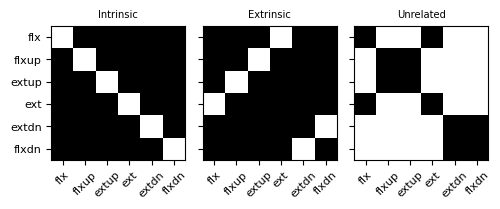

/var/folders/sc/kmc7_9gn2hqd_lrnhdt_2s580000gn/T/ipykernel_10885/707019803.py:62: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), ha='right', rotation=45)


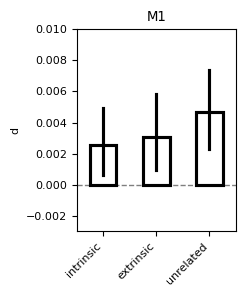

M1
TEST: Mean of intrinsic distances > 0
    t(23): 2.3727, p-value: 0.0132
TEST: Mean of extrinsic distances > 0
    t(23): 2.3668, p-value: 0.0134
TEST: Mean of unrelated distances > 0
    t(23): 3.4176, p-value: 0.0012

intrinsic vs extrinsic
    t(23): -0.7158, p-value: 0.4813
intrinsic vs unrelated
    t(23): -1.8490, p-value: 0.0774
extrinsic vs unrelated
    t(23): -1.4362, p-value: 0.1644


In [9]:
mask_intrinsic = np.eye(6) # picking the same exact intrinsic conditions: e.g., flx:flx, flxup:flxup, ...

mask_extrinsic = np.zeros((6,6)) # picking the extrinsicly similar conditions (moving to the same direction in space): e.g., flxup:extup, extdn:flxdn, ...
mask_extrinsic[0,3] = 1
mask_extrinsic[3,0] = 1
mask_extrinsic[1,2] = 1
mask_extrinsic[2,1] = 1
mask_extrinsic[4,5] = 1
mask_extrinsic[5,4] = 1

mask_unrelated = np.ones((6,6)) - mask_intrinsic - mask_extrinsic # picking the unrelated conditions: e.g., flx:extup, flx:extdn, flxup:flxdn, ...

# visualize masks:
plt.rcParams.update({'font.size': 6})
fig, ax = plt.subplots(1,3,figsize=(5,3), sharex=True, sharey=True)
for i, m in enumerate([mask_intrinsic, mask_extrinsic, mask_unrelated]):
    ax[i].imshow(m, cmap='gray', vmin=0, vmax=1)
    ax[i].set_xticks(np.arange(6))
    ax[i].set_yticks(np.arange(6))
    ax[i].set_xticklabels(labels[:6], fontsize=8, rotation=45)
    ax[i].set_yticklabels(labels[:6], fontsize=8)
    if i == 0:
        ax[i].set_title('Intrinsic')
    elif i == 1:
        ax[i].set_title('Extrinsic')
    elif i == 2:
        ax[i].set_title('Unrelated')
plt.tight_layout()
plt.show()

N = len(Y)
dist = {'type': [], 'd': []}
for i_sub in range(N):
    Di = pcm.G_to_dist(G_hat[i_sub,:,:])
    Di_between = Di[0:6, 6:12]
    Di_within = Di[0:6, 0:6]/2 + Di[6:12, 6:12]/2

    # intrinsic:
    d = Di_between * mask_intrinsic
    dist['type'].append('intrinsic')
    dist['d'].append(np.mean(d[d != 0]))

    # extrinsic:
    d = Di_between * mask_extrinsic
    dist['type'].append('extrinsic')
    dist['d'].append(np.mean(d[d != 0]))

    # unrelated:
    d = Di_between * mask_unrelated
    dist['type'].append('unrelated')
    dist['d'].append(np.mean(d[d != 0]))

df = pd.DataFrame(dist)
plt.rcParams.update({'font.size': 8})
fig, ax = plt.subplots(1,1,figsize=(2.5,3))
# sns.boxplot(data=df, x='type', y='d', width=0.5, fill=False, color='k', ax=ax)
sns.barplot(data=df, x='type', y='d', width=0.5, fill=False, color='k', ax=ax)
# sns.stripplot(data=df, x='type', y='d', size=6, color='k', alpha=0.7, ax=ax)
# set ylim as max + 0.01:
ax.set_ylim((-0.003, 0.01))
# rotate xticks:
ax.set_xticklabels(ax.get_xticklabels(), ha='right', rotation=45)
ax.set_xlabel('')
ax.set_title(f'{region}')
ax.axhline(0, color='k', linestyle='--', linewidth=1, alpha=0.5)
plt.tight_layout()
plt.show()

# t-test within each type d>0:
print(f'{region}')
for t in df['type'].unique():
    d = df[df['type'] == t]['d']
    tstat, pval = stats.ttest_1samp(d, 0, alternative='greater')
    print(f'TEST: Mean of {t} distances > 0')
    print(f'    t({len(d)-1}): {tstat:.4f}, p-value: {pval:.4f}')
print('')
# pairwise t-test between types:
types = df['type'].unique()
for i in range(len(types)):
    for j in range(i+1, len(types)):
        d1 = df[df['type'] == types[i]]['d']
        d2 = df[df['type'] == types[j]]['d']
        tstat, pval = stats.ttest_rel(d1, d2, alternative='two-sided')
        print(f'{types[i]} vs {types[j]}')
        print(f'    t({len(d1)-1}): {tstat:.4f}, p-value: {pval:.4f}')




# MDS

2D coordinates:
[[-0.05422206 -0.03468401]
 [ 0.03012632 -0.02902529]
 [ 0.01285051  0.02075162]
 [-0.0285141   0.02720777]
 [ 0.04203397 -0.00166271]
 [ 0.00052925  0.00771091]
 [-0.03800562 -0.02177856]
 [ 0.02955306 -0.02548171]
 [ 0.01619327  0.02385811]
 [-0.02720331  0.03188695]
 [ 0.01607081 -0.00164951]
 [ 0.00058789  0.00286646]]

Eigenvalues: [0.01017162 0.00599911]

3D coordinates:
[[-5.42220616e-02 -3.46840111e-02  1.62418444e-02]
 [ 3.01263224e-02 -2.90252931e-02 -4.10835226e-03]
 [ 1.28505147e-02  2.07516151e-02  1.76214251e-02]
 [-2.85140955e-02  2.72077662e-02 -8.97507335e-05]
 [ 4.20339699e-02 -1.66271197e-03 -2.00883832e-02]
 [ 5.29246136e-04  7.71090662e-03 -7.66452096e-03]
 [-3.80056214e-02 -2.17785649e-02 -1.96316426e-02]
 [ 2.95530642e-02 -2.54817073e-02 -5.54372213e-03]
 [ 1.61932713e-02  2.38581131e-02  1.11004689e-02]
 [-2.72033061e-02  3.18869452e-02 -2.45123447e-02]
 [ 1.60708087e-02 -1.64951290e-03  1.12042116e-02]
 [ 5.87887265e-04  2.86645523e-03  2.547076

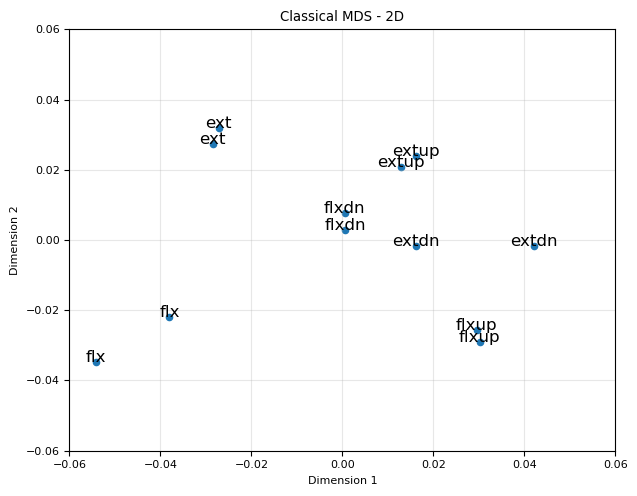

In [219]:
import numpy as np
import matplotlib.cm as cm
import plotly.graph_objects as go

def plot_mds_3d_interactive(coords_3d, labels=None):
    """
    Create an interactive 3D scatter plot for MDS results with equal axes.
    
    Parameters:
    -----------
    coords_3d : numpy.array
        3D coordinates from MDS (N x 3)
    labels : list or None
        Labels for each point (default: numerical indices)
    """
    if labels is None:
        labels = [str(i) for i in range(len(coords_3d))]

    colors = []
    for i in range(len(labels)):
        if i < len(labels)/2:
            colors.append(cm.Blues(i / (len(labels)/2)))
        else:
            colors.append(cm.Reds((i - len(labels)/2) / (len(labels)/2)))
    # make it numpy array, N by 4 RGBA
    colors = np.array(colors)
    colors_hex = [mcolors.to_hex(color) for color in colors]

    # Calculate equal axis limits
    max_range = np.max([
        np.max(coords_3d[:, 0]) - np.min(coords_3d[:, 0]),
        np.max(coords_3d[:, 1]) - np.min(coords_3d[:, 1]),
        np.max(coords_3d[:, 2]) - np.min(coords_3d[:, 2])
    ]) / 2.0
    
    mid_x = (np.max(coords_3d[:, 0]) + np.min(coords_3d[:, 0])) / 2.0
    mid_y = (np.max(coords_3d[:, 1]) + np.min(coords_3d[:, 1])) / 2.0
    mid_z = (np.max(coords_3d[:, 2]) + np.min(coords_3d[:, 2])) / 2.0
    
    fig = go.Figure(data=[go.Scatter3d(
        x=coords_3d[:, 0],
        y=coords_3d[:, 1],
        z=coords_3d[:, 2],
        mode='markers+text',
        marker=dict(
            size=8,
            color=colors_hex,
            showscale=True,
            colorbar=dict(title="Dimension 3")
        ),
        text=labels,
        textposition="top center",
        textfont=dict(size=12),
        hovertemplate='<b>%{text}</b><br>' +
                      'Dim 1: %{x:.3f}<br>' +
                      'Dim 2: %{y:.3f}<br>' +
                      'Dim 3: %{z:.3f}<br>' +
                      '<extra></extra>'
    )])
    
    fig.update_layout(
        title='Interactive 3D MDS Visualization',
        scene=dict(
            xaxis=dict(
                title='Dimension 1',
                range=[mid_x - max_range, mid_x + max_range]
            ),
            yaxis=dict(
                title='Dimension 2',
                range=[mid_y - max_range, mid_y + max_range]
            ),
            zaxis=dict(
                title='Dimension 3',
                range=[mid_z - max_range, mid_z + max_range]
            ),
            aspectmode='cube',  # Force equal aspect ratio
            camera=dict(
                eye=dict(x=1.5, y=1.5, z=1.5)
            )
        ),
        width=800,
        height=700,
        hovermode='closest'
    )
    
    return fig

def classical_mds(D, n_components=2):
    """
    Classical Multidimensional Scaling (MDS) on a dissimilarity matrix.
    
    Also known as Principal Coordinates Analysis (PCoA) or Torgerson's scaling.
    
    Parameters:
    -----------
    D : numpy.array
        Symmetric dissimilarity/distance matrix (N x N)
    n_components : int, default=2
        Number of dimensions for the output (2 or 3 for visualization)
    
    Returns:
    --------
    Y : numpy.array
        Configuration matrix (N x n_components) with embedded coordinates
    eigenvalues : numpy.array
        Eigenvalues corresponding to the dimensions
    """
    # Number of points
    n = len(D)
    
    # Centering matrix
    H = np.eye(n) - np.ones((n, n)) / n
    
    # Double centering: B = -0.5 * H * D^2 * H
    B = -H.dot(D**2).dot(H) / 2
    
    # Eigendecomposition
    eigenvalues, eigenvectors = np.linalg.eigh(B)
    
    # Sort by eigenvalue in descending order
    idx = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    
    # Select only positive eigenvalues and corresponding eigenvectors
    positive_idx = eigenvalues > 0
    eigenvalues = eigenvalues[positive_idx]
    eigenvectors = eigenvectors[:, positive_idx]
    
    # Compute coordinates for the requested number of components
    n_components = min(n_components, len(eigenvalues))
    Y = eigenvectors[:, :n_components] @ np.diag(np.sqrt(eigenvalues[:n_components]))
    
    return Y, eigenvalues[:n_components]

np.random.seed(42)
D = D_hat_avg

# Perform classical MDS to 2D
coords_2d, eigenvals_2d = classical_mds(D, n_components=2)
print("2D coordinates:")
print(coords_2d)
print("\nEigenvalues:", eigenvals_2d)

# Perform classical MDS to 3D
coords_3d, eigenvals_3d = classical_mds(D, n_components=3)
print("\n3D coordinates:")
print(coords_3d)
print("\nEigenvalues:", eigenvals_3d)

# Optional: Plot the results
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# 2D plot
plt.subplot(121)
plt.scatter(coords_2d[:, 0], coords_2d[:, 1], s=20)
for i in range(len(coords_2d)):
    plt.annotate(f'{labels[i]}', (coords_2d[i, 0], coords_2d[i, 1]), 
                fontsize=12, ha='center')
max_range = 0.06
plt.xlim((-max_range, max_range))
plt.ylim((-max_range, max_range))
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('Classical MDS - 2D')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Create labels (e.g., condition names)
fig = plot_mds_3d_interactive(coords_3d, labels=labels)
fig.show()

